In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

In [2]:
DATA_DIR = "./data_cn"

IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 100

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


In [4]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(IMAGE_SIZE, padding=4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
    ]
)

In [5]:
train_dset = datasets.CIFAR10(
    root=DATA_DIR, train=True, download=True, transform=train_transform
)
test_dset = datasets.CIFAR10(
    root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [8]:
class LayerNormChannels(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)

    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.norm(x)
        x = x.transpose(-1, 1)
        return x

In [9]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return x + self.gamma * self.residual(x)

In [10]:
class ConvNeXtBlock(Residual):
    def __init__(self, channels, kernel_size, mult=4, p_drop=0.0):
        padding = (kernel_size - 1) // 2
        hidden_channels = channels * mult
        super().__init__(
            nn.Conv2d(
                channels, channels, kernel_size, padding=padding, groups=channels
            ),
            LayerNormChannels(channels),
            nn.Conv2d(channels, hidden_channels, 1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, channels, 1),
            nn.Dropout(p_drop),
        )

In [11]:
class DownsampleBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__(
            LayerNormChannels(in_channels),
            nn.Conv2d(in_channels, out_channels, stride, stride=stride),
        )

In [12]:
class Stage(nn.Sequential):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, p_drop=0.0):
        layers = (
            []
            if in_channels == out_channels
            else [DownsampleBlock(in_channels, out_channels)]
        )
        layers += [
            ConvNeXtBlock(out_channels, kernel_size, p_drop=p_drop)
            for _ in range(num_blocks)
        ]
        super().__init__(*layers)

In [13]:
class ConvNeXtBody(nn.Sequential):
    def __init__(
        self, in_channels, channel_list, num_blocks_list, kernel_size, p_drop=0.0
    ):
        layers = []
        for out_channels, num_blocks in zip(channel_list, num_blocks_list):
            layers.append(
                Stage(in_channels, out_channels, num_blocks, kernel_size, p_drop)
            )
            in_channels = out_channels
        super().__init__(*layers)

In [14]:
class Stem(nn.Sequential):
    def __init__(self, in_channels, out_channels, patch_size):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, patch_size, stride=patch_size),
            LayerNormChannels(out_channels),
        )

In [15]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LayerNorm(in_channels),
            nn.Linear(in_channels, classes),
        )

In [16]:
class ConvNeXt(nn.Sequential):
    def __init__(
        self,
        classes,
        channel_list,
        num_blocks_list,
        kernel_size,
        patch_size,
        in_channels=3,
        res_p_drop=0.0,
    ):
        super().__init__(
            Stem(in_channels, channel_list[0], patch_size),
            ConvNeXtBody(
                channel_list[0], channel_list, num_blocks_list, kernel_size, res_p_drop
            ),
            Head(channel_list[-1], classes),
        )
        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.zeros_(m.bias)
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)

    def separate_parameters(self):
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, nn.Conv2d)
        modules_no_weight_decay = (nn.LayerNorm,)

        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name

                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        # sanity check
        assert len(parameters_decay & parameters_no_decay) == 0
        assert len(parameters_decay) + len(parameters_no_decay) == len(
            list(model.parameters())
        )

        return parameters_decay, parameters_no_decay

In [20]:
model = ConvNeXt(
    NUM_CLASSES,
    channel_list=[64, 128, 256, 512],
    num_blocks_list=[2, 2, 2, 2],
    kernel_size=7,
    patch_size=1,
    res_p_drop=0.0,
)

In [21]:
model.load_state_dict(torch.load('/home/athar/LeanLearn/convnext.pt'))

model.to(DEVICE)

ConvNeXt(
  (0): Stem(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): LayerNormChannels(
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (1): ConvNeXtBody(
    (0): Stage(
      (0): ConvNeXtBlock(
        (residual): Sequential(
          (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
          (1): LayerNormChannels(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          (3): GELU(approximate='none')
          (4): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
          (5): Dropout(p=0.0, inplace=False)
        )
      )
      (1): ConvNeXtBlock(
        (residual): Sequential(
          (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
          (1): LayerNormChannels(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
    

In [22]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 6,376,466


In [23]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = model.separate_parameters()

    optim_groups = [
        {
            "params": [param_dict[pn] for pn in parameters_decay],
            "weight_decay": weight_decay,
        },
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

In [24]:
loss = nn.CrossEntropyLoss()
optimizer = get_optimizer(model, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)
lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS
)
trainer.add_event_handler(
    Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step()
)
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [25]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)
history = defaultdict(list)

In [26]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history["train loss"].append(train_loss)

    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history["val loss"].append(val_loss)
    history["val acc"].append(val_acc)

    print(
        "{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
            epoch, max_epochs, train_loss, val_loss, val_acc
        )
    )

In [27]:
trainer.run(train_loader, max_epochs=10)

1/10 - train: loss 0.003; val: loss 0.455 accuracy 0.914
2/10 - train: loss 0.003; val: loss 0.484 accuracy 0.911
3/10 - train: loss 0.006; val: loss 0.466 accuracy 0.911
4/10 - train: loss 0.008; val: loss 0.455 accuracy 0.910
5/10 - train: loss 0.012; val: loss 0.443 accuracy 0.911
6/10 - train: loss 0.017; val: loss 0.449 accuracy 0.907
7/10 - train: loss 0.025; val: loss 0.436 accuracy 0.908
8/10 - train: loss 0.050; val: loss 0.408 accuracy 0.901
9/10 - train: loss 0.069; val: loss 0.399 accuracy 0.898
10/10 - train: loss 0.079; val: loss 0.443 accuracy 0.886


State:
	iteration: 15630
	epoch: 10
	epoch_length: 1563
	max_epochs: 10
	output: 0.0059930551797151566
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [25]:
def plot_history_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history["train " + key]) + 1)
    ax.plot(xs, history["train " + key], ".-", label="train")
    ax.plot(xs, history["val " + key], ".-", label="val")
    ax.set_xlabel("epoch")
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()


def plot_history(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history[key]) + 1)
    ax.plot(xs, history[key], "-")
    ax.set_xlabel("epoch")
    ax.set_ylabel(key)
    ax.grid()
    plt.show()

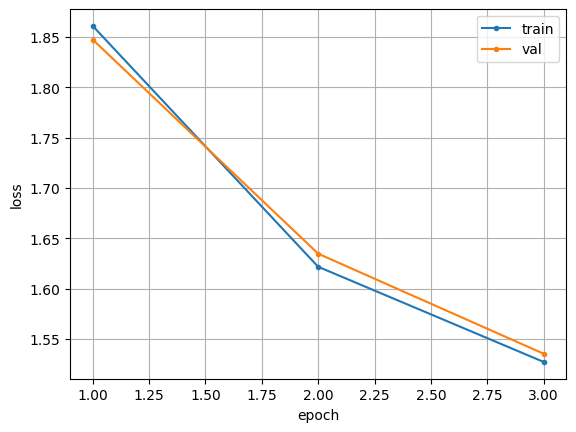

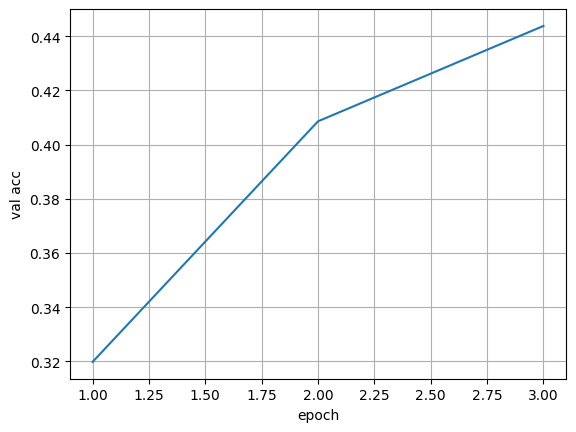

In [26]:
plot_history_train_val(history, "loss")

plot_history(history, "val acc")

In [28]:
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.append(os.path.abspath("../"))

import torch
import torch_pruning as tp

In [33]:
model = ConvNeXt(
    NUM_CLASSES,
    channel_list=[64, 128, 256, 512],
    num_blocks_list=[2, 2, 2, 2],
    kernel_size=7,
    patch_size=1,
    res_p_drop=0.0,
)

model.load_state_dict(torch.load('/home/athar/LeanLearn/convnext.pt'))

model.to(DEVICE)

ConvNeXt(
  (0): Stem(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): LayerNormChannels(
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (1): ConvNeXtBody(
    (0): Stage(
      (0): ConvNeXtBlock(
        (residual): Sequential(
          (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
          (1): LayerNormChannels(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          (3): GELU(approximate='none')
          (4): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
          (5): Dropout(p=0.0, inplace=False)
        )
      )
      (1): ConvNeXtBlock(
        (residual): Sequential(
          (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
          (1): LayerNormChannels(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
    

In [34]:
example_inputs = torch.rand(64, 3, 32, 32).to(DEVICE)

# 0. importance criterion for parameter selections
imp = tp.importance.MagnitudeImportance(p=2, group_reduction='mean')

# 1. ignore some layers that should not be pruned, e.g., the final classifier layer.
ignored_layers = []
for m in model.modules():
    if isinstance(m, torch.nn.Linear) and m.out_features == 10:
        ignored_layers.append(m) # DO NOT prune the final classifier!

        
# 2. Pruner initialization
iterative_steps = 5 # You can prune your model to the target pruning ratio iteratively.
pruner = tp.pruner.MagnitudePruner(
    model, 
    example_inputs, 
    global_pruning=False, # If False, a uniform ratio will be assigned to different layers.
    importance=imp, # importance criterion for parameter selection
    iterative_steps=iterative_steps, # the number of iterations to achieve target ratio
    pruning_ratio=0.5, # remove 50% channels, ResNet18 = {64, 128, 256, 512} => ResNet18_Half = {32, 64, 128, 256}
    ignored_layers=ignored_layers,
)

base_macs, base_nparams = tp.utils.count_ops_and_params(model, example_inputs)
for i in range(iterative_steps):
    # 3. the pruner.step will remove some channels from the model with least importance
    pruner.step()
    
    # 4. Do whatever you like here, such as fintuning
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    print(model)
    print(model(example_inputs).shape)
    print(
        "  Iter %d/%d, Params: %.2f M => %.2f M"
        % (i+1, iterative_steps, base_nparams / 1e6, nparams / 1e6)
    )
    print(
        "  Iter %d/%d, MACs: %.2f G => %.2f G"
        % (i+1, iterative_steps, base_macs / 1e9, macs / 1e9)
    )

ConvNeXt(
  (0): Stem(
    (0): Conv2d(3, 57, kernel_size=(1, 1), stride=(1, 1))
    (1): LayerNormChannels(
      (norm): LayerNorm((57,), eps=1e-05, elementwise_affine=True)
    )
  )
  (1): ConvNeXtBody(
    (0): Stage(
      (0): ConvNeXtBlock(
        (residual): Sequential(
          (0): Conv2d(57, 57, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=57)
          (1): LayerNormChannels(
            (norm): LayerNorm((57,), eps=1e-05, elementwise_affine=True)
          )
          (2): Conv2d(57, 230, kernel_size=(1, 1), stride=(1, 1))
          (3): GELU(approximate='none')
          (4): Conv2d(230, 57, kernel_size=(1, 1), stride=(1, 1))
          (5): Dropout(p=0.0, inplace=False)
        )
      )
      (1): ConvNeXtBlock(
        (residual): Sequential(
          (0): Conv2d(57, 57, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=57)
          (1): LayerNormChannels(
            (norm): LayerNorm((57,), eps=1e-05, elementwise_affine=True)
          )
    

In [38]:
trainer.run(train_loader, max_epochs=10)

7/10 - train: loss 0.264; val: loss 0.167 accuracy 0.942
8/10 - train: loss 0.181; val: loss 0.179 accuracy 0.937
9/10 - train: loss 0.167; val: loss 0.193 accuracy 0.933
10/10 - train: loss 0.168; val: loss 0.187 accuracy 0.933


State:
	iteration: 2817
	epoch: 10
	epoch_length: 313
	max_epochs: 10
	output: 0.13473081588745117
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [40]:
max(history['val acc'])

1.0